In [1]:
# ! pip install matplotlib
#! pip install ipywidgets IPython

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
import ipywidgets as widgets
from IPython.display import display
from matplotlib.gridspec import GridSpec # 레이아웃 제어를 위해 추가

In [3]:
# 이 부분을 님의 컴퓨터(로컬)에서 주석 해제하고 사용하세요.
os_name = platform.system()
if os_name == 'Windows':
    font_path = 'c:/Windows/Fonts/malgun.ttf' # 윈도우용 (맑은 고딕)
elif os_name == 'Darwin':
    font_path = '/System/Library/Fonts/AppleGothic.ttf' # 맥용
else:
    # 리눅스 등 (나눔고딕 설치 가정)
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

try:
    font_name = fm.FontProperties(fname=font_path).get_name()
    plt.rc('font', family=font_name)
    plt.rc('axes', unicode_minus=False) # 마이너스 기호 깨짐 방지
    print(f"한글 폰트 적용 완료: {font_name}")
except Exception as e:
    print(f"폰트 설정 실패 (기본 폰트 사용): {e}")

한글 폰트 적용 완료: Malgun Gothic


In [4]:
# 데이터 로드
df = pd.read_csv('raw_data.csv')
match_info = pd.read_csv('match_info.csv')

In [5]:
# ---------------------------------------------------------
# [STEP 1] 선수 이름 입력 -> 경기 리스트 출력 함수 (소속팀 추가)
# ---------------------------------------------------------
def get_match_history(player_name):
    # 1. raw_data에서 해당 선수의 데이터 추출
    player_data = df[df['player_name_ko'] == player_name]
    
    if len(player_data) == 0:
        print(f"❌ '{player_name}' 선수의 데이터를 찾을 수 없습니다.")
        return None
    
    # [수정] game_id와 함께 'team_name_ko'(당시 소속팀)도 같이 추출합니다.
    # drop_duplicates를 통해 경기당 하나의 팀 정보만 남깁니다.
    player_game_info = player_data[['game_id', 'team_name_ko']].drop_duplicates()
    
    # 2. 경기 정보 매칭 (match_info)
    history = match_info[match_info['game_id'].isin(player_game_info['game_id'])].copy()
    
    # [수정] 경기 정보표(history)에 선수의 소속팀 정보(player_game_info)를 합칩니다.
    history = pd.merge(history, player_game_info, on='game_id', how='left')
    
    # 3. 보기 좋게 정리 (날짜순 정렬)
    history['game_date'] = pd.to_datetime(history['game_date'])
    history = history.sort_values('game_date', ascending=False)
    
    # 4. 출력용 컬럼 선택 (소속팀 추가)
    # 컬럼 순서: ID | 날짜 | 소속팀 | 홈팀 | 스코어 | 원정팀
    display_cols = ['game_id', 'game_date', 'team_name_ko', 'home_team_name_ko', 'home_score', 'away_score', 'away_team_name_ko']
    result_df = history[display_cols].reset_index(drop=True)
    
    # 보기 좋게 컬럼명 한글로 변경
    result_df.columns = ['Game ID', '날짜', '선수 소속팀', '홈팀', '홈', '원정', '원정팀']
    
    print(f"\n📅 [{player_name}] 최근 경기 기록 (총 {len(result_df)}경기)")
    print("="*100) # 구분선 좀 더 길게
    print(result_df.to_string(index=False))
    print("="*100)
    print("👉 분석하고 싶은 경기의 'Game ID'를 복사하세요.\n")
    
    return result_df

In [18]:
# ---------------------------------------------------------
# [STEP 2] Game ID 입력 -> 4분할 전술 분석 출력 함수
# ---------------------------------------------------------
def visualize_match_tactics(target_game_id, player_name):
    # 1. 경기 정보 확인
    match_meta = match_info[match_info['game_id'] == target_game_id]
    if len(match_meta) == 0:
        print("❌ 유효하지 않은 Game ID입니다.")
        return

    meta = match_meta.iloc[0]
    title_text = f"{meta['game_date']} | {meta['home_team_name_ko']} vs {meta['away_team_name_ko']} ({meta['home_score']}:{meta['away_score']})"
    
    # 2. 해당 경기 데이터 필터링
    df_game = df[df['game_id'] == target_game_id].copy()
    
    # 3. 패스 연결 데이터 구축 (Passer -> Receiver)
    df_sorted = df_game.sort_values(['action_id'])
    passes = df_sorted[(df_sorted['type_name'] == 'Pass') & (df_sorted['result_name'] == 'Successful')]
    connections = passes[passes['type_name'].shift(-1) == 'Pass Received'].copy()
    
    connections['receiver_name'] = df_sorted['player_name_ko'].shift(-1)
    connections['receive_x'] = df_sorted['start_x'].shift(-1)
    connections['receive_y'] = df_sorted['start_y'].shift(-1)

    # 데이터셋 준비
    all_passes = df_game[(df_game['player_name_ko'] == player_name) & (df_game['type_name'] == 'Pass')]
    success_passes = df_game[(df_game['player_name_ko'] == player_name) & (df_game['type_name'] == 'Pass') & (df_game['result_name'] == 'Successful')]
    fail_passes = df_game[(df_game['player_name_ko'] == player_name) & (df_game['type_name'] == 'Pass') & (df_game['result_name'] == 'Unsuccessful')]
    received = connections[connections['receiver_name'] == player_name]
    
    # (데이터, 색상, 제목, 범례라벨)
    datasets = [
        (all_passes, 'tab:purple', '1. All Passes', 'Total'),
        (success_passes, 'tab:blue', '2. Success', 'Succ'),
        (fail_passes, 'tab:red', '3. Failed', 'Fail'),
        (received, 'tab:green', '4. Received', 'Recv')
        ]
    
    # 4. 시각화 (GridSpec 사용: 3행 2열)
    # figsize=(가로, 세로): 세로 비율을 늘림
    fig = plt.figure(figsize=(20, 24)) 
    gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.2]) # 마지막 행을 조금 더 크게
    plt.suptitle(f"Tactical Summary (2-2-1 Layout): {player_name}\n{title_text}", fontsize=24, fontweight='bold', y=0.95)
    
    # 그리기 루프
    def draw_pitch(ax, title_str):
        ax.plot([0, 0], [0, 68], color='black'); ax.plot([0, 105], [68, 68], color='black')
        ax.plot([105, 105], [68, 0], color='black'); ax.plot([105, 0], [0, 0], color='black')
        ax.plot([52.5, 52.5], [0, 68], color='gray', linestyle='--')
        ax.plot([0, 16.5], [13.84, 13.84], color='black'); ax.plot([16.5, 16.5], [13.84, 54.16], color='black'); ax.plot([16.5, 0], [54.16, 54.16], color='black')
        ax.plot([105, 88.5], [13.84, 13.84], color='black'); ax.plot([88.5, 88.5], [13.84, 54.16], color='black'); ax.plot([88.5, 105], [54.16, 54.16], color='black')
        ax.set_xlim(-5, 110); ax.set_ylim(-5, 73); ax.axis('off')
        ax.set_title(title_str, fontsize=15, fontweight='bold', pad=12)
    
    # --- [Step 1] 1~4번 차트 그리기 (개별 분포 + 평균 별) ---
    for i, (data, color, title, label) in enumerate(datasets):
        # Grid 위치 계산: 0,1번은 0행 / 2,3번은 1행
        row = i // 2
        col = i % 2
        
        ax = fig.add_subplot(gs[row, col])
        draw_pitch(ax, title)
        
        if len(data) > 0:
            # 좌표 설정
            x_col = 'receive_x' if i == 3 else 'start_x'
            y_col = 'receive_y' if i == 3 else 'start_y'
            
            # 1) 전체 점 찍기 (작고 투명하게)
            ax.scatter(data[x_col], data[y_col], c=color, s=50, alpha=0.3, edgecolors='none')
            
            # 2) 평균 위치 계산 및 '큰 별' 찍기
            avg_x = data[x_col].mean()
            avg_y = data[y_col].mean()
            ax.scatter(avg_x, avg_y, c=color, s=400, marker='*', edgecolors='black', linewidth=1.5, zorder=10, label='Avg Pos')
            
            # 3) 텍스트 표시
            ax.text(avg_x, avg_y-6, f"({avg_x:.0f},{avg_y:.0f})", ha='center', fontsize=11, fontweight='bold', color='black')
            ax.text(52.5, -5, f"Count: {len(data)}", ha='center', fontsize=12)
        else:
            ax.text(52.5, 34, "No Data", ha='center', fontsize=14)

    # --- [Step 2] 5번 차트 그리기 (종합 비교) ---
    # gs[2, :] -> 3번째 행의 모든 열(2개)을 합쳐서(span) 중앙에 배치
    ax_summary = fig.add_subplot(gs[2, :])
    draw_pitch(ax_summary, "5. Summary (Avg Comparison)")
    
    # 가로 비율이 깨지지 않게 Aspect Ratio 조정 (선택 사항)
    ax_summary.set_aspect('equal')

    draw_pitch(ax_summary, "5. Summary (Avg Comparison)")
    
    # 4가지 데이터셋의 '평균 별'만 모아서 찍기
    for i, (data, color, title, label) in enumerate(datasets):
        if len(data) > 0:
            x_col = 'receive_x' if i == 3 else 'start_x'
            y_col = 'receive_y' if i == 3 else 'start_y'
            
            avg_x = data[x_col].mean()
            avg_y = data[y_col].mean()
            
            # 평균 위치 별 찍기 (Legend를 위해 label 지정)
            ax_summary.scatter(avg_x, avg_y, c=color, s=600, marker='*', edgecolors='black', linewidth=1.5, label=label, zorder=10)
            
            # 텍스트로 어떤 별인지 약어 표시 (선택사항)
            ax_summary.text(avg_x, avg_y+4, label, ha='center', fontsize=10, fontweight='bold')

    # 범례 추가 (5번 차트에만)
    ax_summary.legend(loc='upper right', fontsize=10, framealpha=0.8)
    ax_summary.text(52.5, -5, "Avg Position Comparison", ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()
    
def select_game_id_interactive(df, id_col='game_id'):
    """
    데이터프레임에서 사용자 입력을 통해 특정 Game ID를 선택하여 반환합니다.
    df: 경기 기록 데이터프레임
    id_col: Game ID가 들어있는 컬럼명 (기본값: 'game_id')
    """
    if df is None or df.empty:
        print("❌ 선택할 수 있는 경기 기록이 없습니다.")
        return None

    # 컬럼 존재 여부 체크 (비판적 피드백 반영: 오타 방지)
    if id_col not in df.columns:
        print(f"❌ 데이터에 '{id_col}' 컬럼이 없습니다. (현재 컬럼: {list(df.columns)})")
        return None

    valid_ids = df[id_col].unique()

    while True:
        try:
            user_input = input(f"👉 분석할 Game ID를 입력하세요 (총 {len(valid_ids)}경기): ").strip()
            selected_id = int(user_input)

            if selected_id in valid_ids:
                print(f"✅ Game ID [{selected_id}] 선택 완료.")
                return selected_id  # 값을 반환하고 함수 종료
            else:
                print(f"❌ 목록에 없는 ID입니다. 다시 확인해주세요.")
        
        except ValueError:
            print("❌ 숫자로만 입력해주세요.")

In [15]:
# 1. 선수 이름 입력 및 기록 조회
target_player = '박진섭'
match_list = get_match_history(target_player)



📅 [박진섭] 최근 경기 기록 (총 22경기)
 Game ID                  날짜    선수 소속팀          홈팀  홈  원정         원정팀
  126477 2024-10-06 06:00:00 전북 현대 모터스        대구FC  4   3   전북 현대 모터스
  126472 2024-09-28 10:00:00 전북 현대 모터스   전북 현대 모터스  2   1     제주SK FC
  126468 2024-09-22 10:00:00 전북 현대 모터스   대전 하나 시티즌  0   0   전북 현대 모터스
  126461 2024-09-14 10:00:00 전북 현대 모터스        수원FC  0   6   전북 현대 모터스
  126454 2024-09-01 10:00:00 전북 현대 모터스   전북 현대 모터스  0   0        FC서울
  126446 2024-08-24 10:30:00 전북 현대 모터스    인천 유나이티드  0   1   전북 현대 모터스
  126441 2024-08-17 10:00:00 전북 현대 모터스   전북 현대 모터스  2   1     포항 스틸러스
  126433 2024-08-09 10:30:00 전북 현대 모터스   전북 현대 모터스  0   1        광주FC
  126420 2024-07-14 10:00:00 전북 현대 모터스 김천 상무 프로축구단  4   0   전북 현대 모터스
  126413 2024-07-10 10:30:00 전북 현대 모터스   전북 현대 모터스  2   1     제주SK FC
  126407 2024-07-07 10:00:00 전북 현대 모터스   대전 하나 시티즌  2   2   전북 현대 모터스
  126373 2024-06-01 07:30:00 전북 현대 모터스    울산 HD FC  1   0   전북 현대 모터스
  126372 2024-05-29 10:30:00 전북 현대 모터스        강원FC  2   1   전북 

👉 분석할 Game ID를 입력하세요 (총 22경기):  126301


✅ Game ID [126301] 선택 완료.


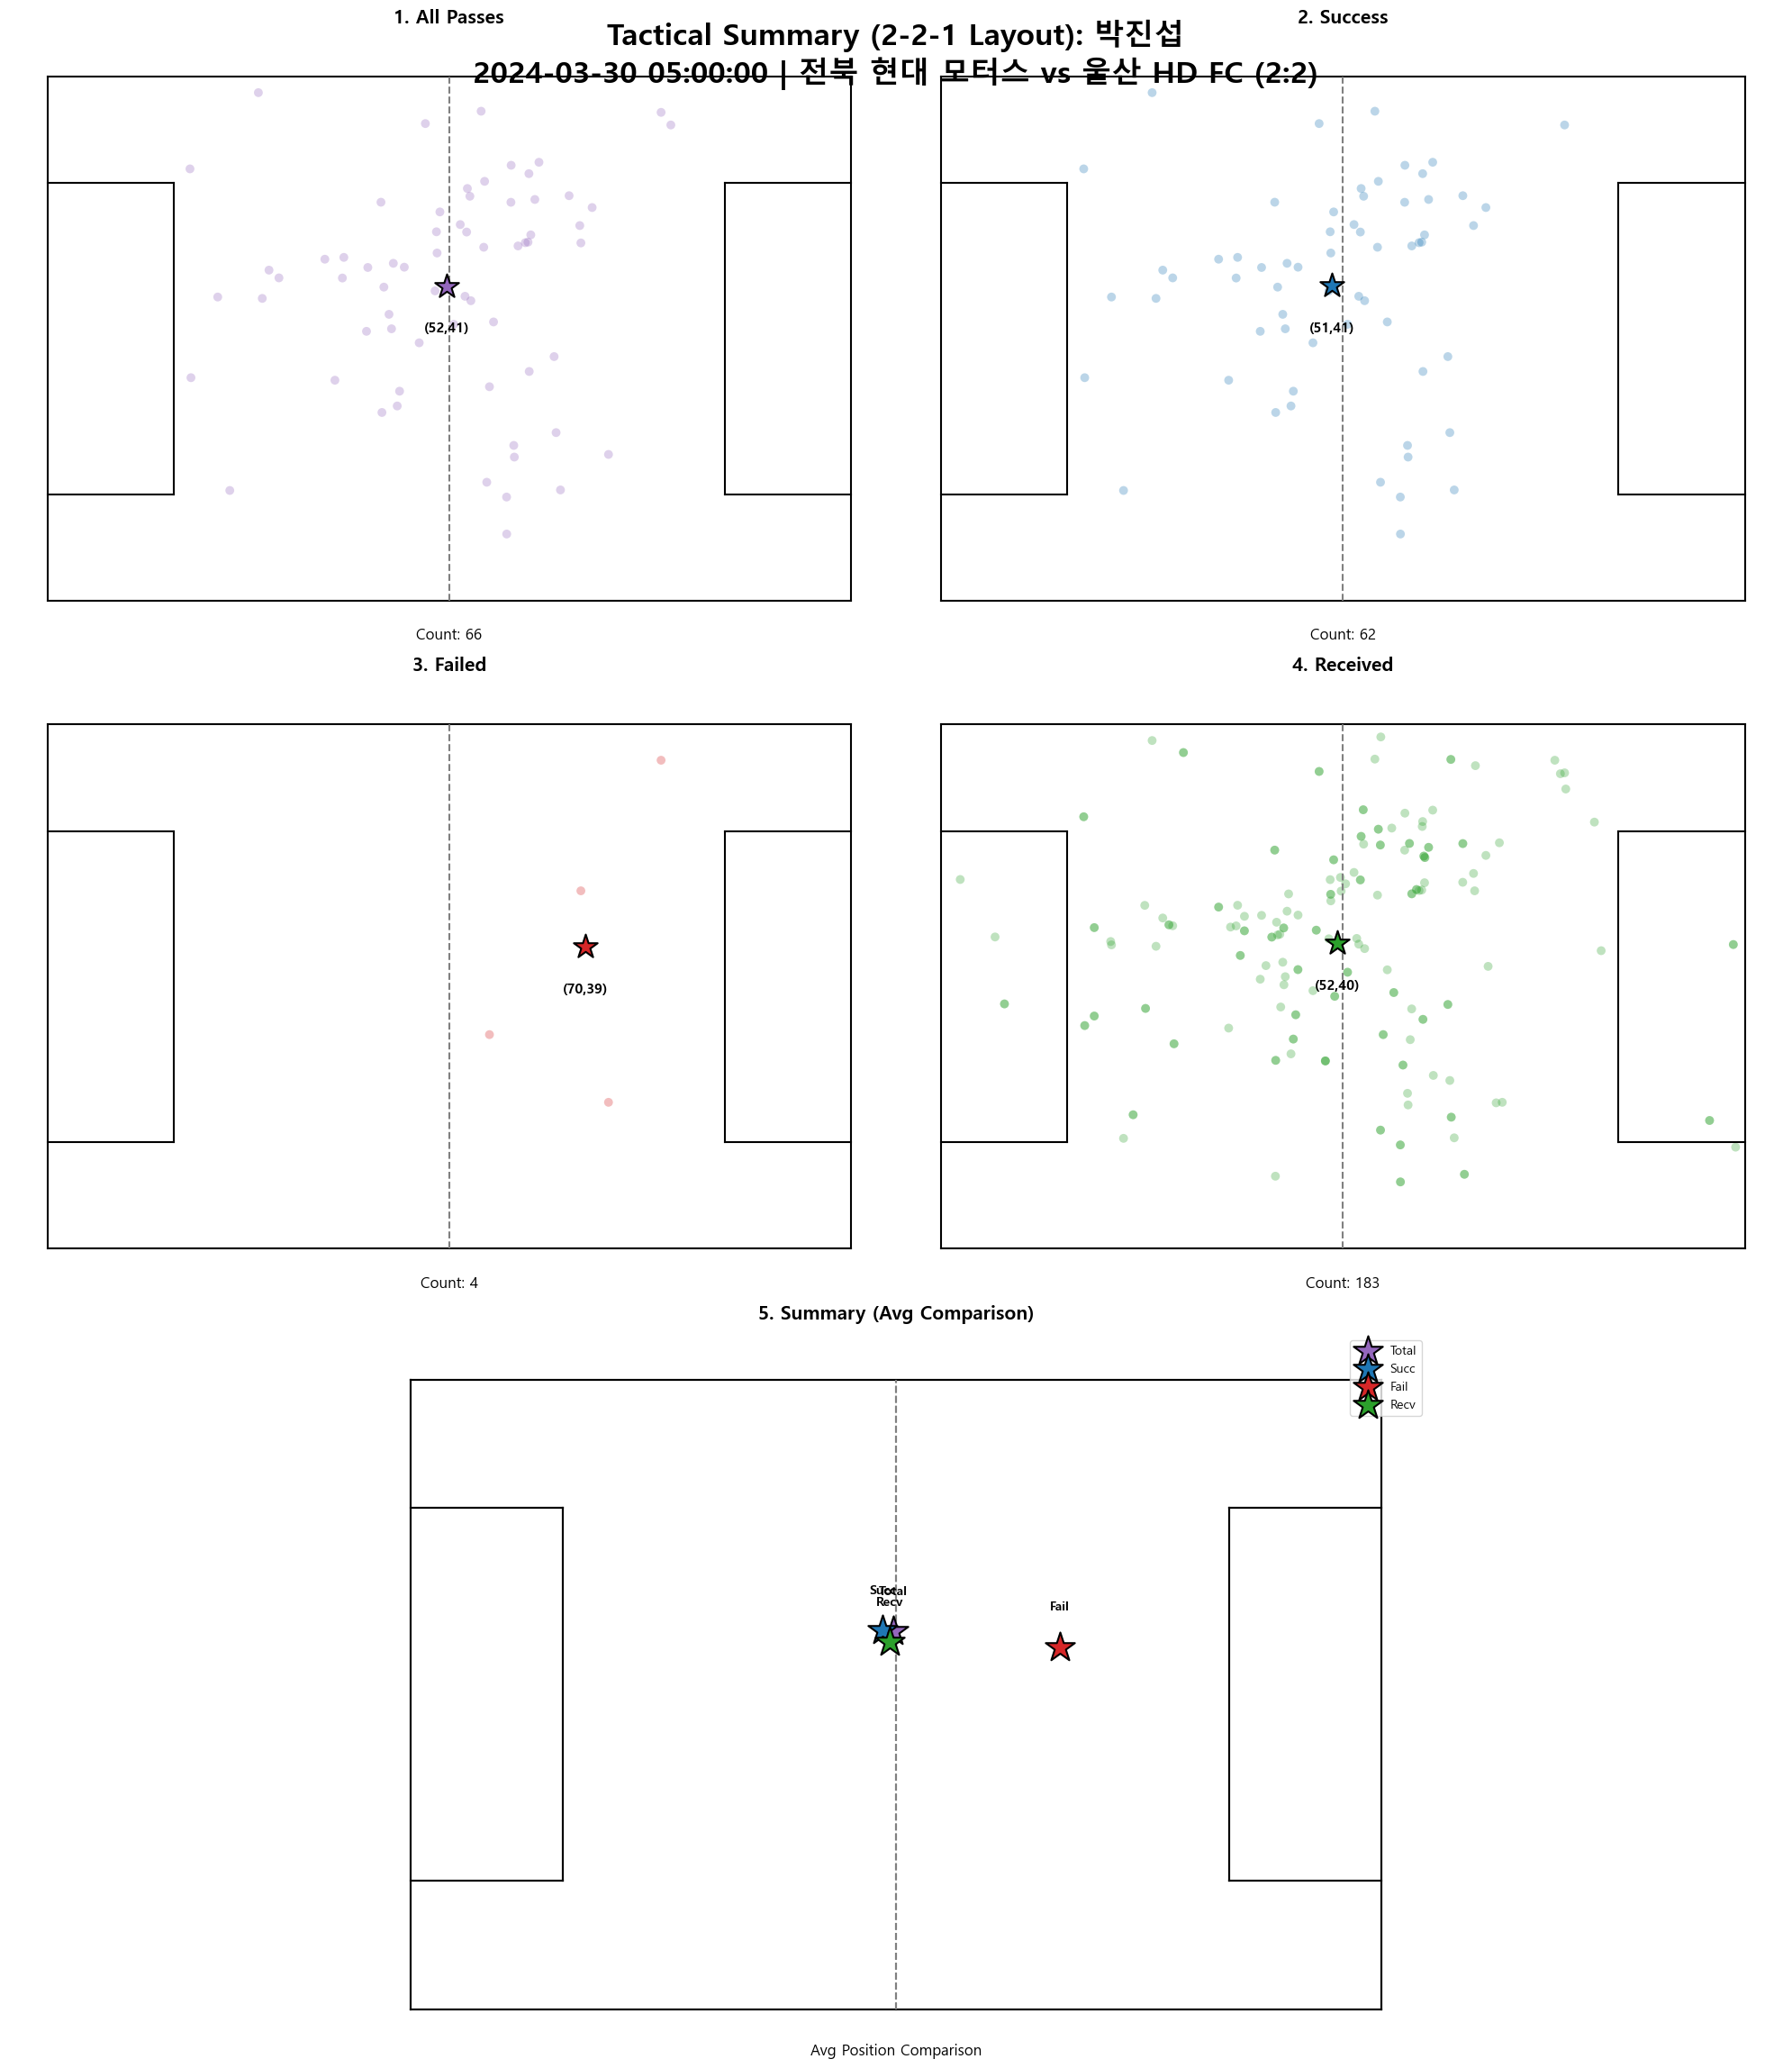

In [19]:
# 2. 함수 호출로 ID 받기 (컬럼명이 'Game ID'라면 두 번째 인자에 명시)
selected_game_id = select_game_id_interactive(match_list, id_col='Game ID') 

# 3. ID가 정상적으로 반환되었을 때만 시각화 실행
if selected_game_id:
    visualize_match_tactics(selected_game_id, target_player)